## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_26-31-05-23.csv', firstRow=552, lastRow=558)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_300523_S553-558.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=58s and ended at t=482s; mass=43.883100000000006g
This equals a volume of 43.971m; expected was 44.487mL; error is 1.16%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0010000000000000002 g/s and for 2nd derivative = 0.00025 g/s^2


<IPython.core.display.Javascript object>


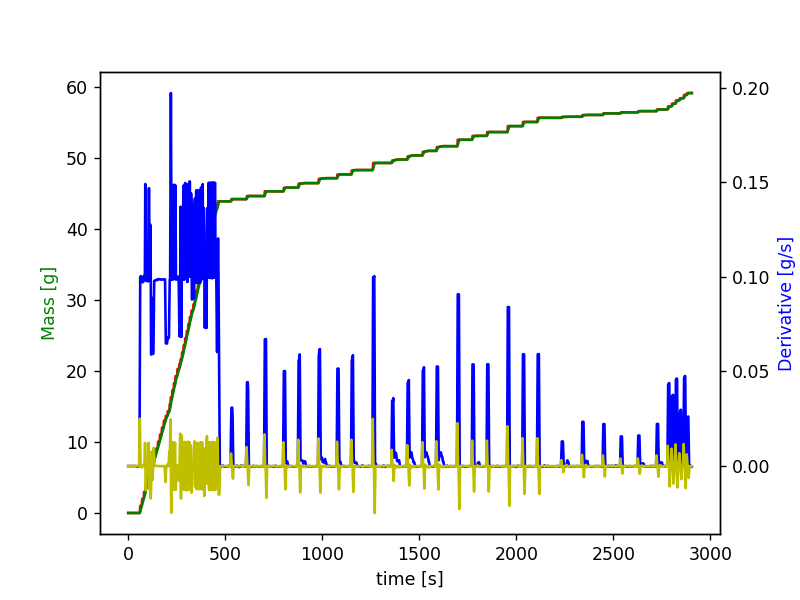

Addition of 0.307g Texapon SB 3 KC detected from 524s to 546s - expected volume = 0.531mL and actual volume = 0.276mL (resulting error is 48.054%)
Addition of 0.441g Texapon SB 3 KC detected from 604s to 626s - expected volume = 0.531mL and actual volume = 0.397mL (resulting error is 25.33%)
Addition of 0.669g Texapon SB 3 KC detected from 698s to 718s - expected volume = 0.924mL and actual volume = 0.601mL (resulting error is 34.985%)
Addition of 0.526g Plantapon ACG 50 detected from 796s to 828s - expected volume = 0.519mL and actual volume = 0.467mL (resulting error is 10.0%)
Addition of 0.641g Plantapon ACG 50 detected from 872s to 920s - expected volume = 0.519mL and actual volume = 0.57mL (resulting error is 9.76%)
Addition of 0.699g Plantacare 2000 detected from 976s to 1026s - expected volume = 0.737mL and actual volume = 0.638mL (resulting error is 13.432%)
Addition of 0.537g Dehyton MC detected from 1072s to 1102s - expected volume = 0.531mL and actual volume = 0.494mL (resul

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.0003125 g/s^2


<IPython.core.display.Javascript object>


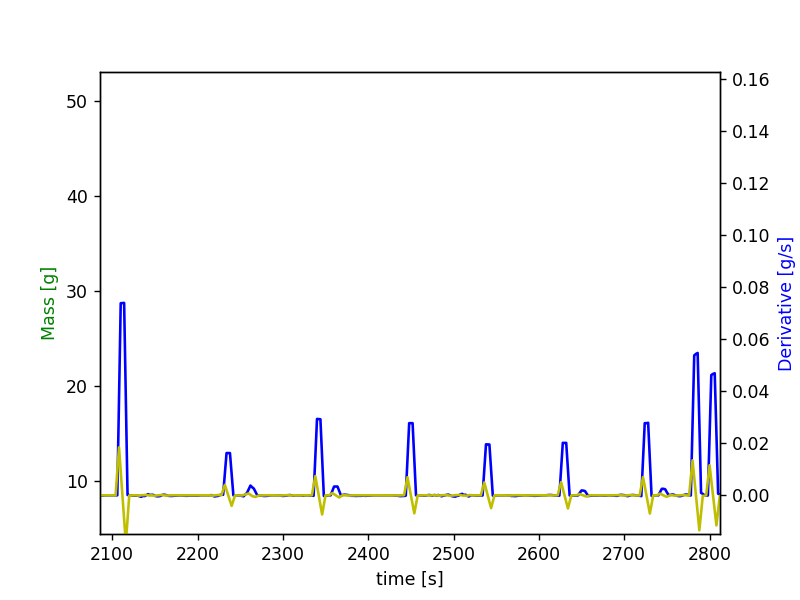

Addition of 0.158g Salcare Super 7 detected from 2228s to 2274s - expected volume = 0.195mL and actual volume = 0.144mL (resulting error is 26.11%)
Addition of 0.26g Salcare Super 7 detected from 2334s to 2372s - expected volume = 0.264mL and actual volume = 0.235mL (resulting error is 11.002%)
Addition of 0.221g Salcare Super 7 detected from 2442s to 2460s - expected volume = 0.198mL and actual volume = 0.2mL (resulting error is 0.799%)
Addition of 0.156g Salcare Super 7 detected from 2532s to 2550s - expected volume = 0.128mL and actual volume = 0.14mL (resulting error is 9.595%)
Addition of 0.172g Salcare Super 7 detected from 2622s to 2660s - expected volume = 0.142mL and actual volume = 0.155mL (resulting error is 9.177%)
Addition of 0.24g Salcare Super 7 detected from 2718s to 2754s - expected volume = 0.229mL and actual volume = 0.217mL (resulting error is 5.04%)


In [5]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=7, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


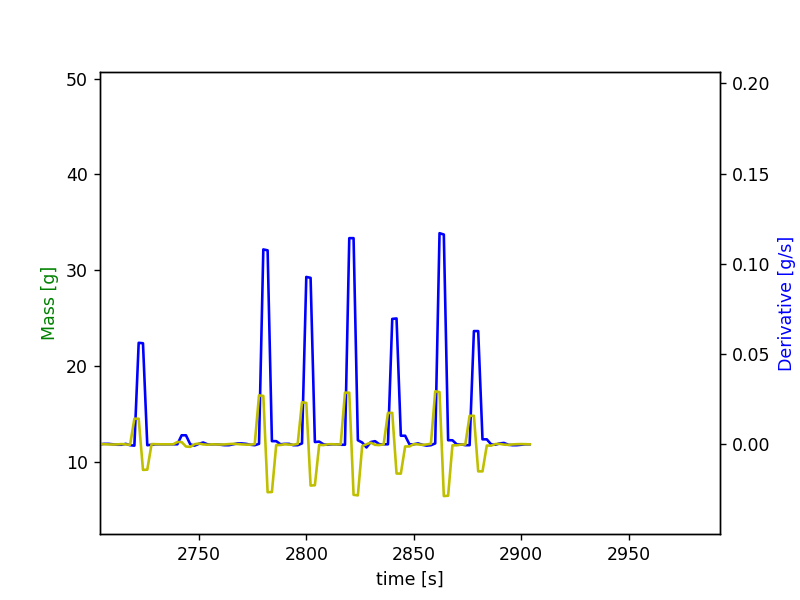

Addition of 0.437g Arlypon F detected from 2776s to 2788s - expected volume = 0.492mL and actual volume = 0.502mL (resulting error is 2.103%)
Addition of 0.374g Arlypon F detected from 2796s to 2808s - expected volume = 0.4mL and actual volume = 0.428mL (resulting error is 7.0%)
Addition of 0.459g Arlypon F detected from 2816s to 2828s - expected volume = 0.501mL and actual volume = 0.524mL (resulting error is 4.556%)
Addition of 0.298g Arlypon F detected from 2836s to 2852s - expected volume = 0.309mL and actual volume = 0.339mL (resulting error is 9.743%)
Addition of 0.474g Arlypon F detected from 2858s to 2870s - expected volume = 0.512mL and actual volume = 0.539mL (resulting error is 5.333%)
Addition of 0.26g Arlypon F detected from 2874s to 2886s - expected volume = 0.273mL and actual volume = 0.297mL (resulting error is 8.787%)


In [6]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2780,2834,2844,2848,2862,2884,2906])

## Consolidate results and create output

In [7]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_300523_S553-S558.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_35084\2480596591.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
552,553.0,0.000000,11.620189,0.0,0.0,0.000000,0.000000,0.000000,10.563355,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.575041,4.352839,0.0
553,554.0,7.721546,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,9.372552,0.000000,0.0,0.0,0.0,0.0,0.0,2.681594,3.864385,0.0
554,555.0,6.849200,0.000000,0.0,0.0,0.000000,0.000000,10.333181,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2.260031,4.699227,0.0
555,556.0,0.000000,0.000000,0.0,0.0,6.946543,0.000000,0.000000,0.000000,10.884177,0.000000,0.0,0.0,0.0,0.0,0.0,1.547460,2.968141,0.0
556,557.0,0.000000,0.000000,0.0,0.0,0.000000,11.369264,0.000000,0.000000,0.000000,8.299721,0.0,0.0,0.0,0.0,0.0,1.704204,4.682857,0.0
557,558.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,12.787643,0.000000,11.539711,0.0,0.0,0.0,0.0,0.0,2.344141,2.536844,0.0
